<a href="https://colab.research.google.com/github/AlexRibeir012/SPARKIFY/blob/main/Sparkify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparkify Project Workspace

In this workspace, we will work with a subset of the full dataset.

*SUMMARY*
- Load an Clean the dataset
- Explanatory Data Analysis
- Feature Engineering
- Modeling

We will select the best options to use in the full dataset, which is contained in the `Sparkify-Full.ipynb` notebook

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [825 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [52.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,265 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.types import IntegerType, DoubleType

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler

from pyspark.ml.functions import vector_to_array

from pyspark.ml.recommendation import ALS

from pyspark.ml.linalg import Vectors
from pyspark.mllib.linalg.distributed import CoordinateMatrix, IndexedRowMatrix

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140

In [ ]:
spark = SparkSession.builder\
    .appName("Sparkify Ratings")\
    .master("spark://192.168.0.15:7077")\
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

In [ ]:
df = spark.read.json("mini_sparkify_event_data.json")
print(df.count())

286500


In [ ]:
count = df.count()
columns = df.columns
print("Number of rows:", count)
print("Columns:", columns)


Number of rows: 286500
Columns: ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


We have **286.500** recorded events

In [ ]:
df.createOrReplaceTempView("sparkify_events")

Remove null or blank `userId` and `sessionId`

In [ ]:
# Clean Dataset
# Remove userId, sessionId NULL
df = spark.sql("""
SELECT userId, gender, location, level, sessionId, page, artist, song, length, userAgent, registration, ts
FROM sparkify_events
WHERE userId != '' AND userId IS NOT NULL AND sessionId IS NOT NULL
ORDER BY userId, ts
""")
df.createOrReplaceTempView("sparkify_events")

Create indexes for `userId` and `artist` columns

In [ ]:
# Create Indexer for userId and artist
user_indexer = StringIndexer(inputCol="userId", outputCol="userIdIndex")
artist_indexer = StringIndexer(inputCol="artist", outputCol="artistIndex", handleInvalid="keep")

# Create labels for user and artist
user_indexer_model = user_indexer.fit(df)
artist_indexer_model = artist_indexer.fit(df)

# Transform dataframe
df = user_indexer_model.transform(df)
df = artist_indexer_model.transform(df)
df.createOrReplaceTempView("sparkify_events")

Convert `ts` and `registration` column to timestamp columns.

Create `elapsed` column, which is the time that an event occured after registration.

In [ ]:
# Convert timestamp
df = df.withColumn("elapsed", df.ts - df.registration)
df = df.withColumn("timestamp", F.to_timestamp(F.from_unixtime(df.ts/1000)))
df = df.withColumn("registration_date", F.to_timestamp(F.from_unixtime(df.registration/1000)))
df.createOrReplaceTempView("sparkify_events")

In [ ]:
# Elapsed Time in days (Days between registration and activity)
df = df.withColumn("elapsed_days", F.round(df.elapsed/(24*60*60*1000), 0).cast("integer"))
df.createOrReplaceTempView("sparkify_events")

We want to analyse events after a user is registered. Thus remove any event that occured before that user registration.

In [ ]:
# Remove negative elapsed_days
print(df.filter(df.elapsed_days < 0).count())
df = df.filter(df.elapsed_days >= 0)
df.createOrReplaceTempView("sparkify_events")

133


Create a dataframe with a user last week of activity only. This will be used later as a tentative improvement of the model.

In [ ]:
# We will use this afterwards
# Create a View with each userId last week activity
last_week_df = spark.sql("""
SELECT userId, gender, location, level, sessionId, page, artist, song, length, userAgent, registration, ts, userIdIndex, artistIndex, registration_date, timestamp, elapsed, elapsed_days FROM
(
    SELECT *, MAX(ts) OVER(PARTITION BY userId) AS max_ts
    FROM sparkify_events
)
WHERE ts >= max_ts - 7*24*60*60*1000
""")

last_week_df.createOrReplaceTempView("last_week_events")

# Exploratory Data Analysis

### Define Churn

Churn is defined when a user reached the `Cancellation Confirmation` page.


In [ ]:
# Define Churn

# Churn (variable to predict)
churn = spark.sql("""
SELECT userIdIndex, CAST( SUM(IF(page = 'Cancellation Confirmation', 1, 0)) >= 1 AS INT ) AS label FROM sparkify_events
GROUP BY userIdIndex
""")
churn.createOrReplaceTempView("churn")

In [ ]:
# Churn rate
churn_rate = churn.filter(churn.label == 1).count() / churn.count()
print(f"Churn Rate: {churn_rate}")

Churn Rate: 0.2311111111111111


### Explore Data
We explore and visualize some data here. We try to compare the behavior of churned users from those not.

- Check registration dates
- Check the time of last activity
- Check user age during the event window time
- Check the count of users during the event window time
- Check the histogram of user age and mean user age (mean user age is the average age of all events of a user)
- Check the count of users when a user event happened
- Check the number of songs and page interactions per date of activity (the date since registration)

In [ ]:
# Range of registration dates, and activites dates
date_ranges = spark.sql("""
SELECT MIN(date(registration_date)) AS min_registration_date,
       MAX(date(registration_date)) AS max_registration_date,
       MIN(date(timestamp)) AS min_activity_date,
       MAX(date(timestamp)) AS max_activity_date
FROM sparkify_events
""").toPandas()
date_ranges

,min_registration_date,max_registration_date,min_activity_date,max_activity_date
0,2018-03-18,2018-11-26,2018-10-01,2018-12-03


In [ ]:
# Registration date
registration_date = spark.sql("""
SELECT registration, label, COUNT(userIdIndex) AS count FROM
(
    SELECT events.userIdIndex, events.registration, churn.label FROM
    (
        SELECT userIdIndex, MIN(date(registration_date)) AS registration FROM sparkify_events
        GROUP BY userIdIndex
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY registration, label
""")

In [ ]:
reg_df = registration_date.toPandas()
reg_df = reg_df.pivot(index="registration", columns="label").fillna(0)
reg_df.columns = ["Not Cancelled", "Cancelled"]
reg_df_cumsum = reg_df.cumsum()

<Axes: xlabel='Registration Date', ylabel='Cumulative User Count'>

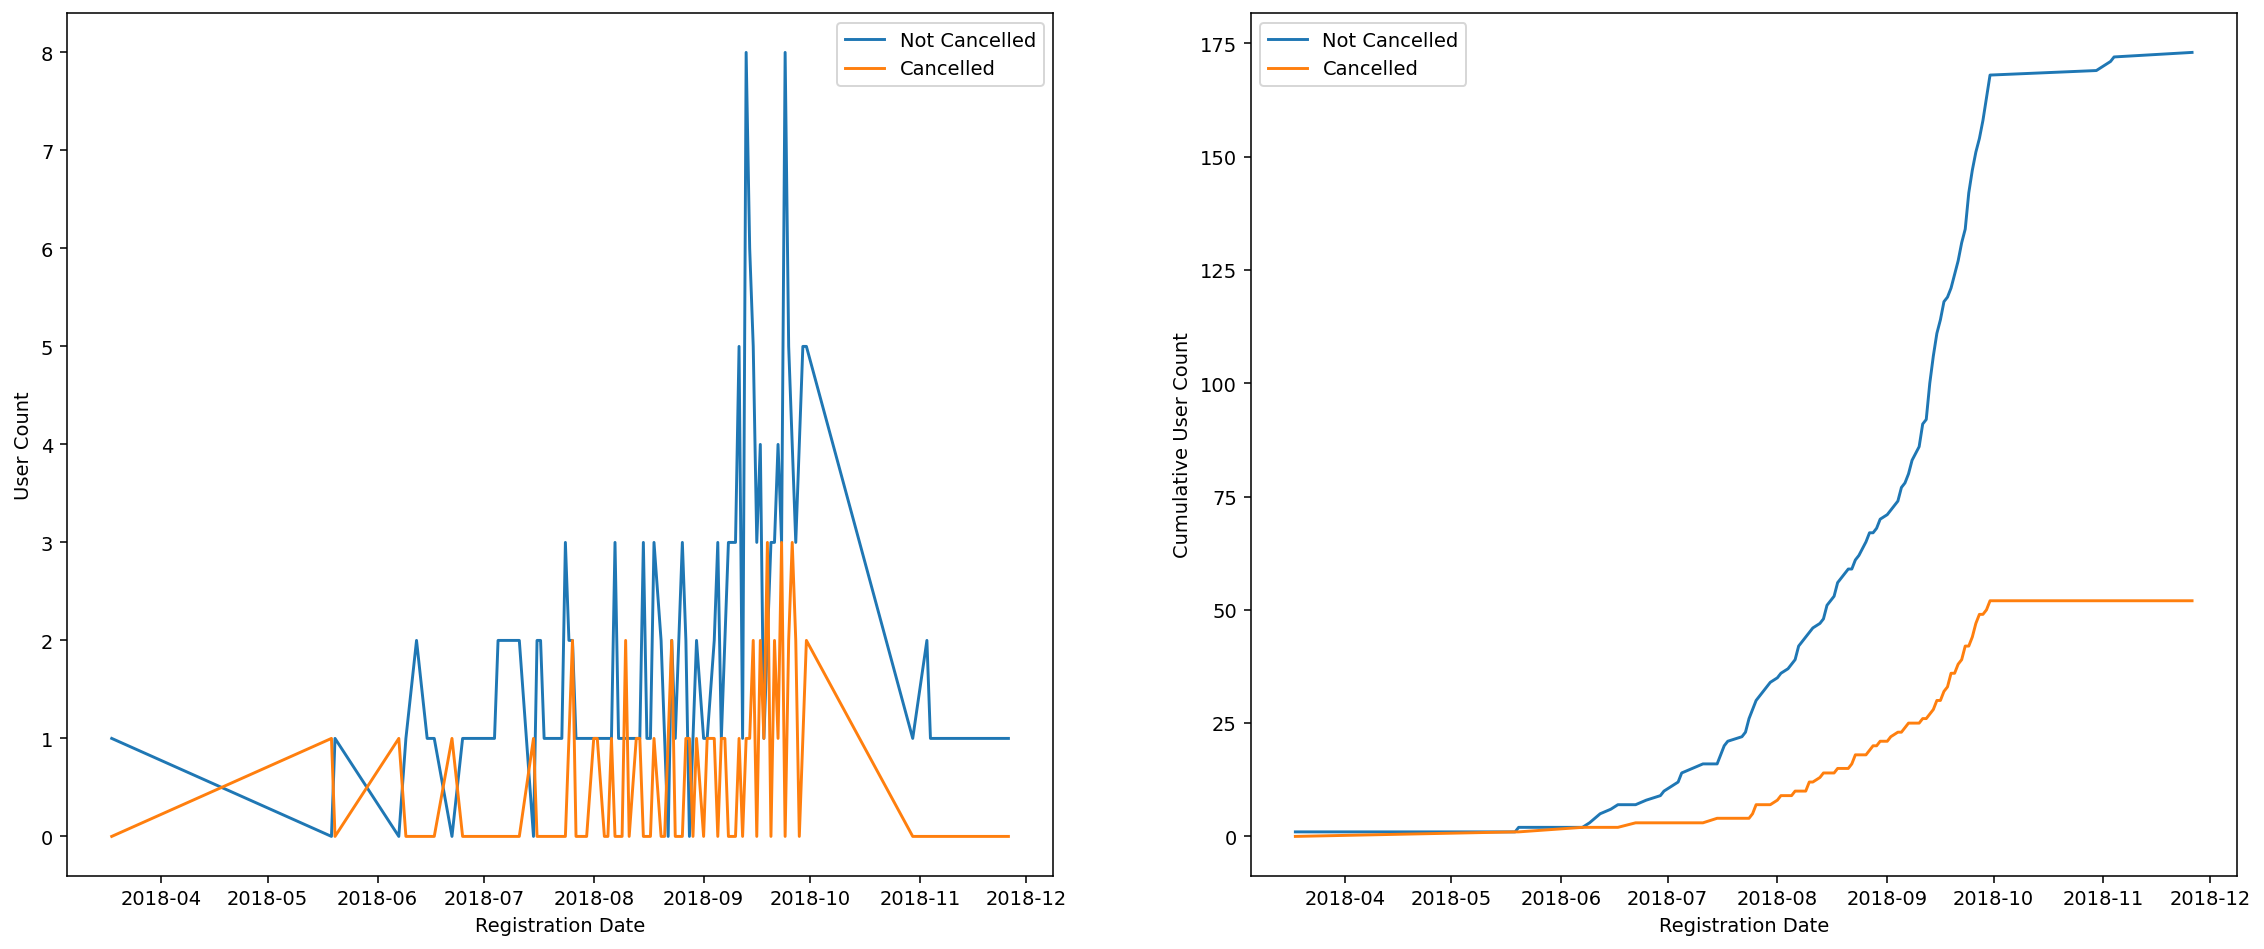

In [ ]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

reg_df.plot(ax=axes[0], xlabel="Registration Date", ylabel="User Count")
reg_df_cumsum.plot(ax=axes[1], xlabel="Registration Date", ylabel="Cumulative User Count")

As expected, most users are registered before the start of the window of events.

In [ ]:
# Last Activity date
last_activity_date = spark.sql("""
SELECT ts, label, COUNT(userIdIndex) AS count FROM
(
    SELECT events.userIdIndex, events.ts, churn.label FROM
    (
        SELECT userIdIndex, MAX(date(timestamp)) AS ts FROM sparkify_events
        GROUP BY userIdIndex
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY ts, label
""")

In [ ]:
lad_df = last_activity_date.toPandas()
lad_df = lad_df.pivot(index="ts", columns="label").fillna(0)
lad_df.columns = ["Not Cancelled", "Cancelled"]
lad_df_cumsum = lad_df.cumsum()

<Axes: xlabel='Last Activity Date', ylabel='Cumulative User Count'>

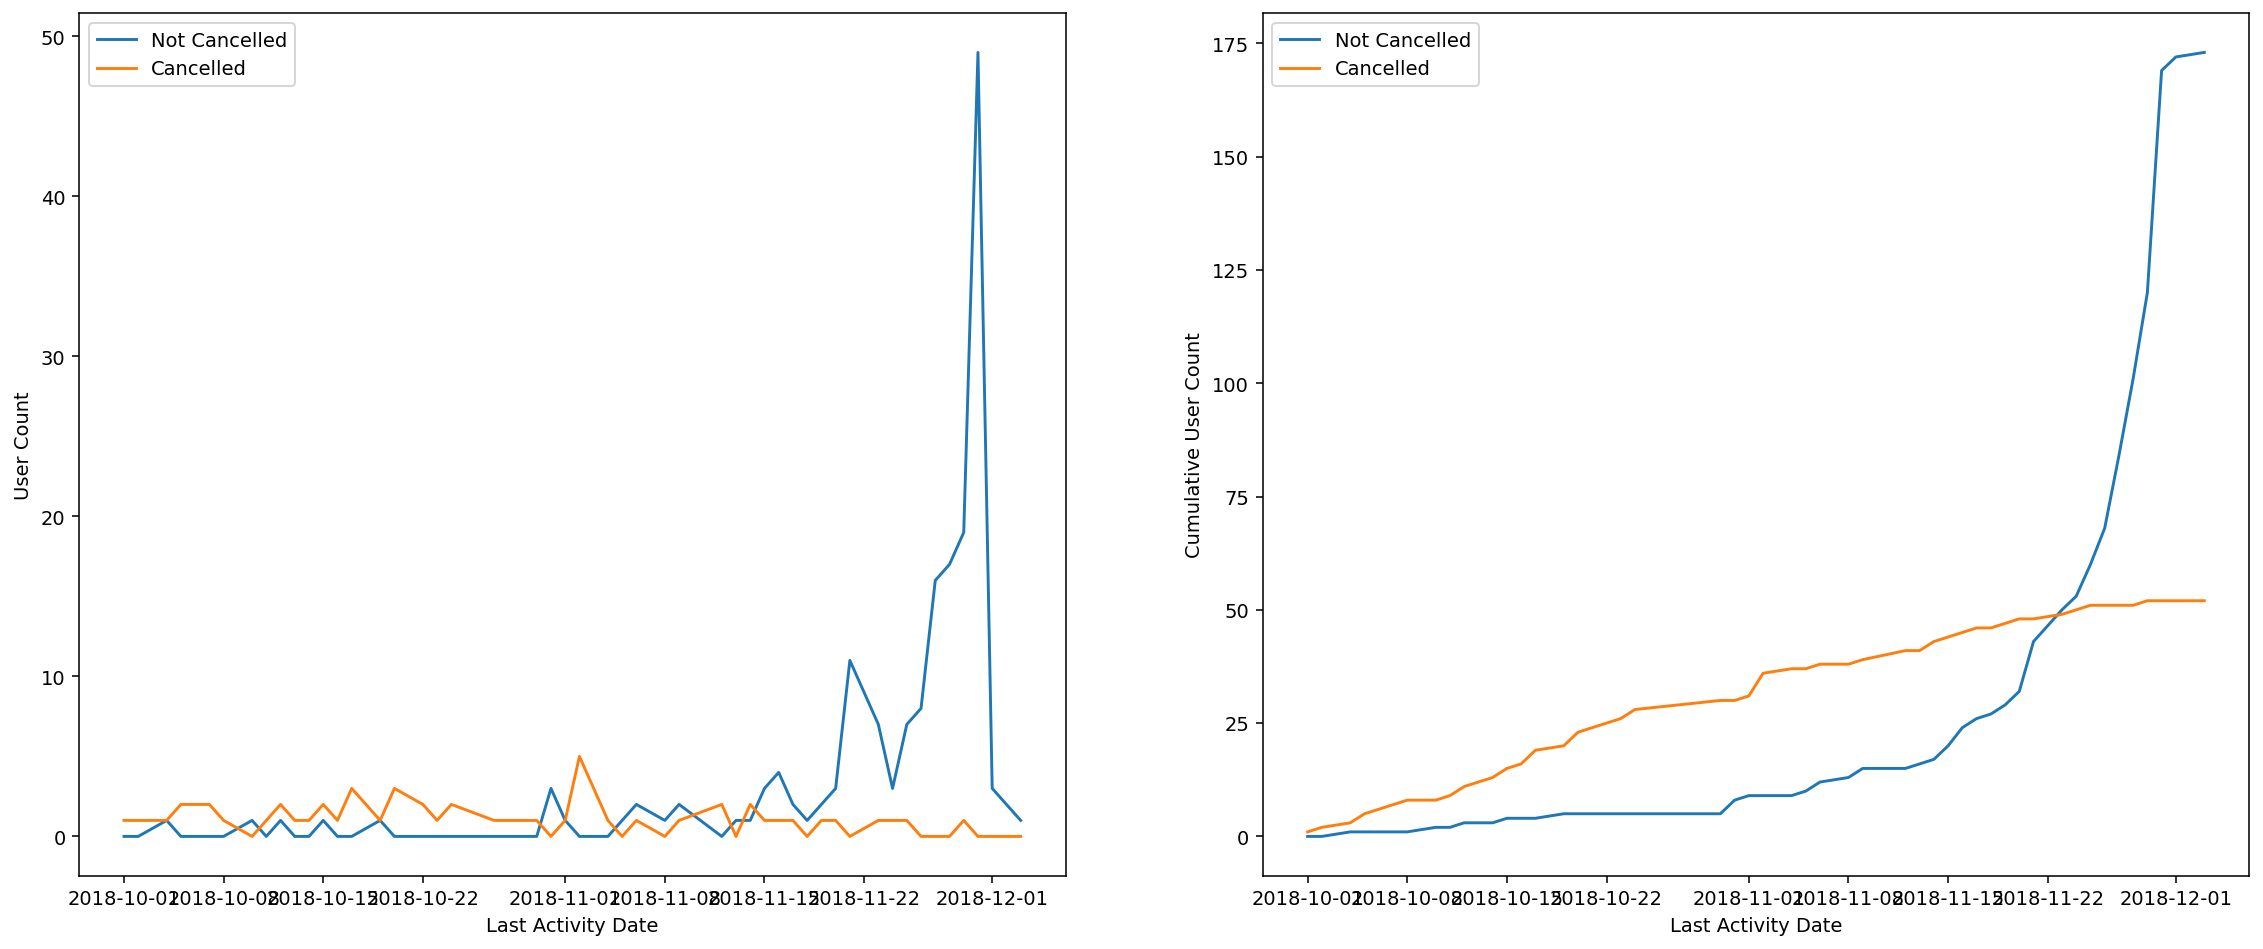

In [ ]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

lad_df.plot(ax=axes[0], xlabel="Last Activity Date", ylabel="User Count")
lad_df_cumsum.plot(ax=axes[1], xlabel="Last Activity Date", ylabel="Cumulative User Count")

Most users that have not cancelled, have their last activity in the end of window time. The others cancel more or less with same rate within the window.

In [ ]:
# Mean User Age Date by Activity Date
mean_user_age = spark.sql("""
SELECT ts, label, COUNT(userIdIndex) AS users, AVG(age) AS age FROM
(
    SELECT events.userIdIndex, events.ts, events.age, churn.label FROM
    (
        SELECT userIdIndex, date(timestamp) AS ts, AVG(elapsed_days) AS age FROM sparkify_events
        GROUP BY userIdIndex, date(timestamp)
    ) AS events
    INNER JOIN churn ON events.userIdIndex = churn.userIdIndex
)
GROUP BY ts, label
""")

In [ ]:
mean_user_age_df = mean_user_age.toPandas()

mua_df = mean_user_age_df.pivot(index="ts", columns="label", values="age").fillna(0)
mua_df.columns = ["Not Cancelled", "Cancelled"]

user_count_df = mean_user_age_df.pivot(index="ts", columns="label", values="users").fillna(0)
user_count_df.columns = ["Not Cancelled", "Cancelled"]

<Axes: xlabel='Activity Date', ylabel='User Count'>

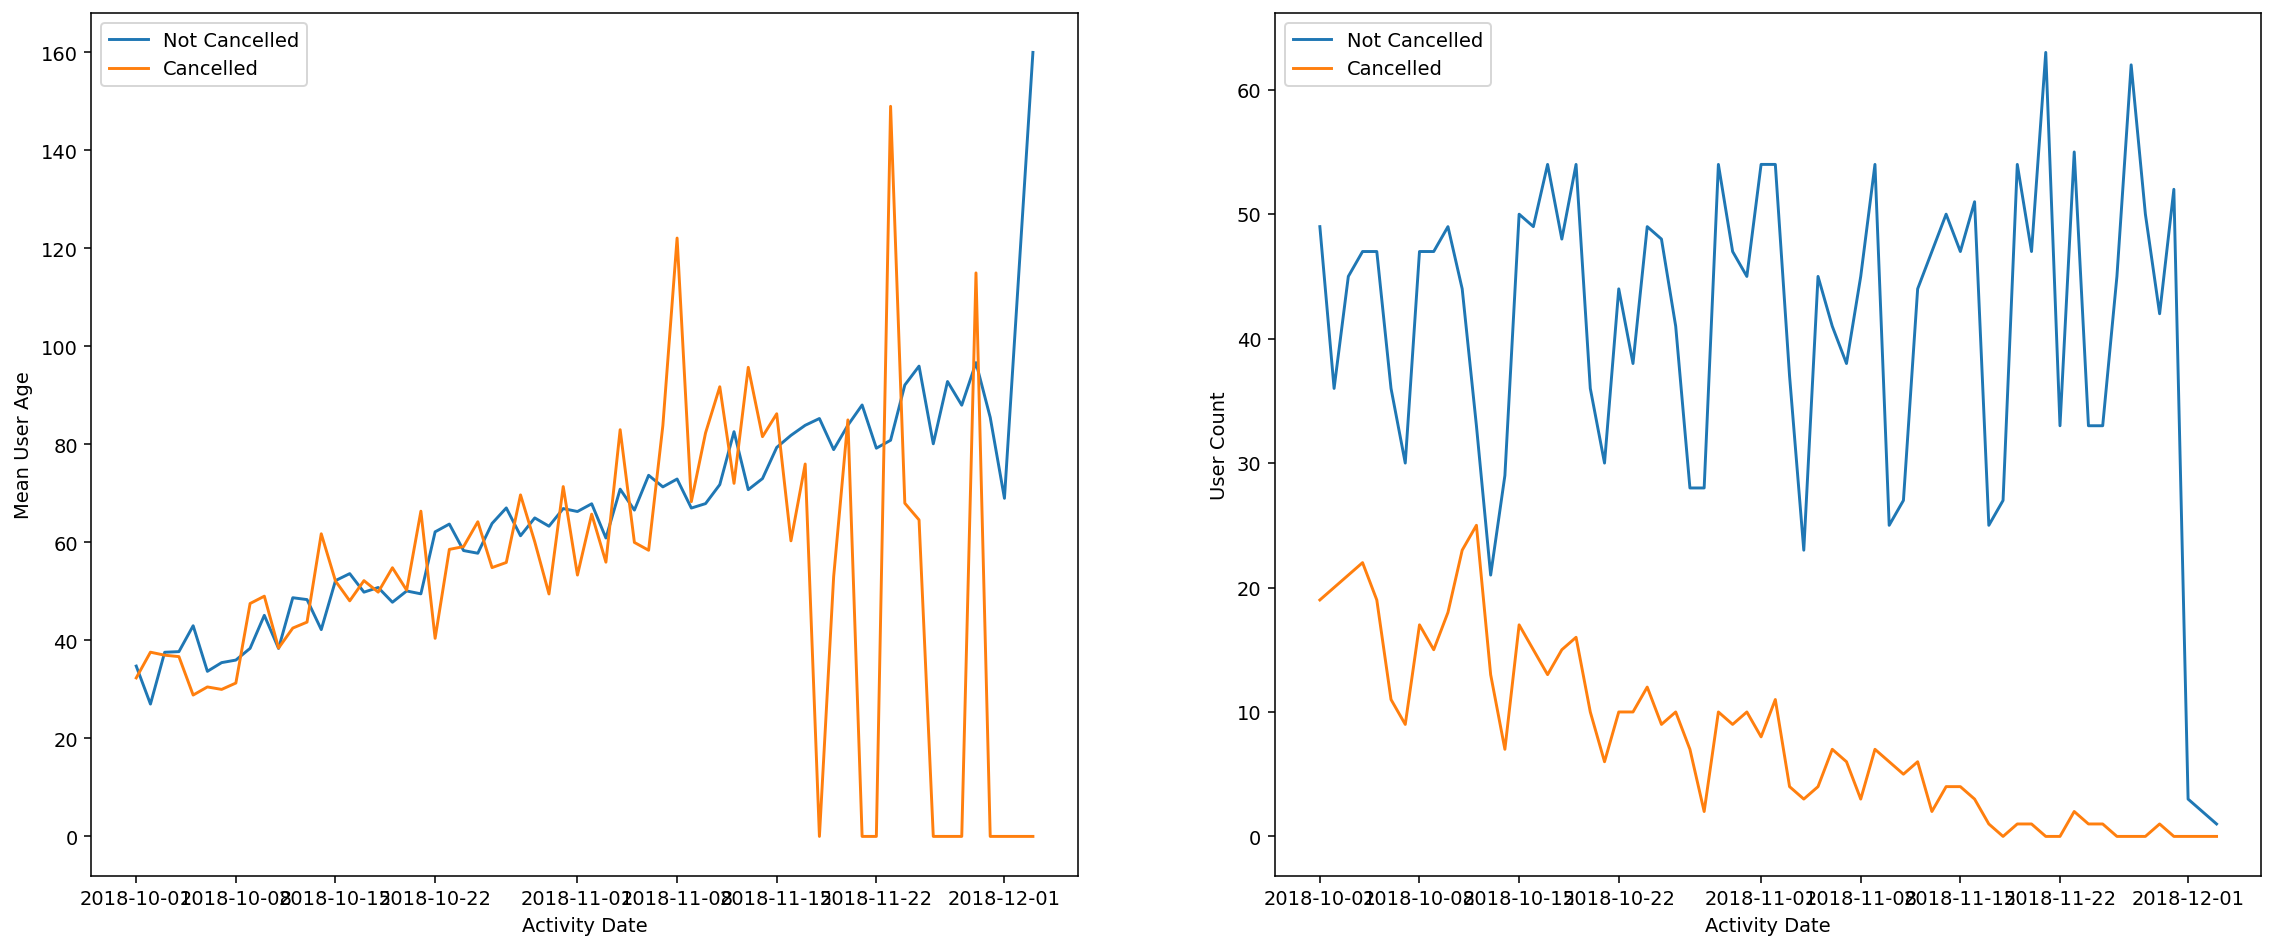

In [ ]:
fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

mua_df.plot(ax=axes[0], xlabel="Activity Date", ylabel="Mean User Age")
user_count_df.plot(ax=axes[1], xlabel="Activity Date", ylabel="User Count")

The mean user age is the same for both group. The end is more noisy due to have less users.

The number of active users remains about the same, while the number of cancelled users increases with time.

We also see a strong seasonal effect in user activity. In the full dataset, this image is even clearer. The activity is higher during Monday to Friday, and decreses in the weekend. We can even notice a drop in November 22 2018, which was Thanksgiving in the United States.

In [ ]:
0# User age distribution
user_age = spark.sql("""
SELECT events.userIdIndex, age, avg_age, label FROM
(
    SELECT userIdIndex, MAX(elapsed_days) AS age, AVG(elapsed_days) AS avg_age
    FROM sparkify_events
    GROUP BY userIdIndex
) AS events
INNER JOIN churn ON churn.userIdIndex = events.userIdIndex
""")

In [ ]:
user_age_df = user_age.toPandas()

Text(0, 0.5, 'User Count')

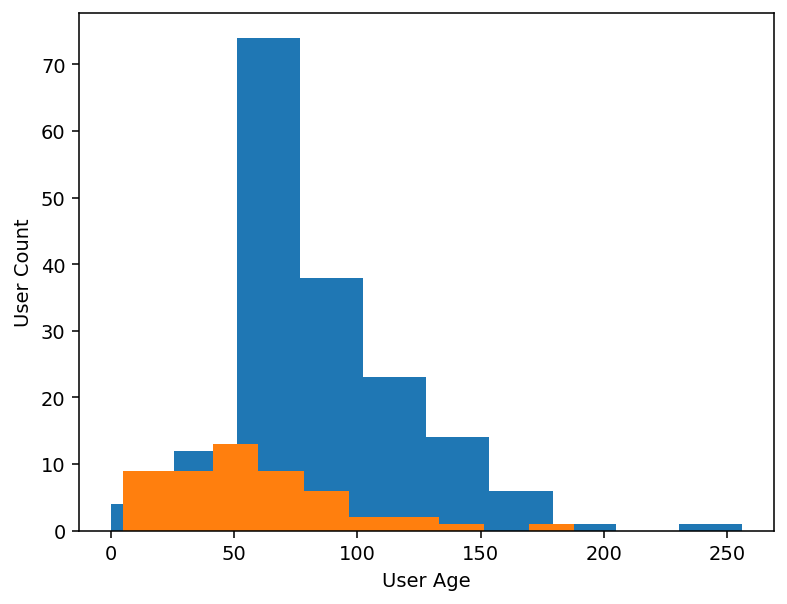

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

user_age_df.loc[user_age_df["label"] == 0, "age"].plot(ax=axes, kind="hist")
user_age_df.loc[user_age_df["label"] == 1, "age"].plot(ax=axes, kind="hist")

axes.set_xlabel("User Age")
axes.set_ylabel("User Count")

Text(0, 0.5, 'User Count')

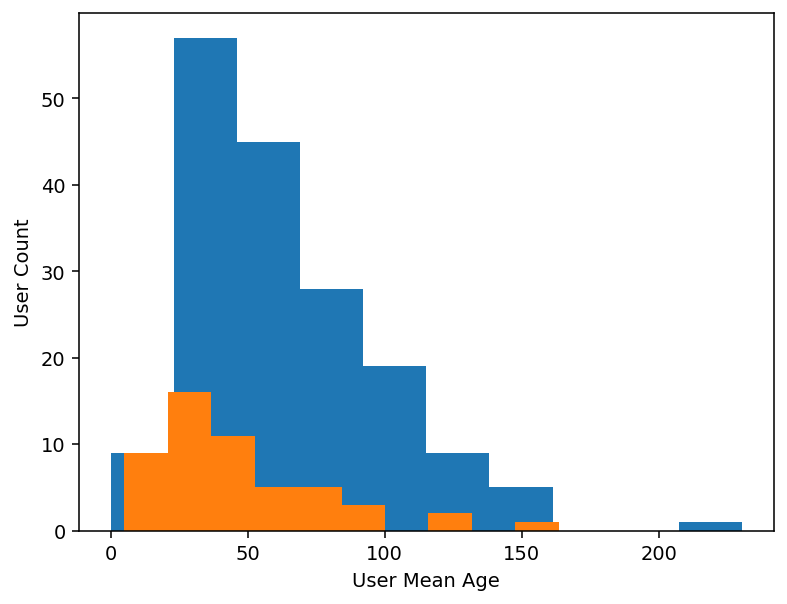

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

user_age_df.loc[user_age_df["label"] == 0, "avg_age"].plot(ax=axes, kind="hist")
user_age_df.loc[user_age_df["label"] == 1, "avg_age"].plot(ax=axes, kind="hist")

axes.set_xlabel("User Mean Age")
axes.set_ylabel("User Count")

In [ ]:
user_age_df.loc[user_age_df["label"] == 0, "age"].describe()

count    173.000000
mean      86.583815
std       35.348764
min        0.000000
25%       65.000000
50%       75.000000
75%      103.000000
max      256.000000
Name: age, dtype: float64

In [ ]:
user_age_df.loc[user_age_df["label"] == 1, "age"].describe()

count     52.000000
mean      57.288462
std       36.620650
min        5.000000
25%       30.750000
50%       51.500000
75%       73.750000
max      188.000000
Name: age, dtype: float64

In [ ]:
user_age_df.loc[user_age_df["label"] == 0, "avg_age"].describe()

count    173.000000
mean      64.290128
std       34.671785
min        0.000000
25%       40.000000
50%       53.937799
75%       83.787976
max      230.393512
Name: avg_age, dtype: float64

In [ ]:
user_age_df.loc[user_age_df["label"] == 1, "avg_age"].describe()

count     52.000000
mean      46.473382
std       32.571108
min        5.000000
25%       24.293399
50%       38.124122
75%       60.069707
max      163.496771
Name: avg_age, dtype: float64

The user age of a user that cancelled the service is 57 days, compare to 86 of those which has not cancelled.

The average age is also lower, 46 vs. 64, respectively.

In [ ]:
# Check song played during time
song_played_per_user_per_day = spark.sql("""
SELECT user_age_when_played, label,
       COUNT(userIdIndex) AS users_count,
       SUM(songs_played) AS songs_played,
       AVG(songs_played) AS avg_songs_played,
       STD(songs_played) AS std_songs_played,
       SUM(page_interactions) AS page_interactions,
       AVG(page_interactions) AS avg_page_interactions,
       STD(page_interactions) AS std_page_interactions
FROM
(
    SELECT events.userIdIndex, events.user_age_when_played, events.songs_played, events.page_interactions, churn.label FROM
    (
        SELECT userIdIndex, elapsed_days AS user_age_when_played, SUM(IF(page = 'NextSong', 1, 0)) AS songs_played, SUM(IF(page = 'NextSong', 0, 1)) AS page_interactions
        FROM sparkify_events
        GROUP BY userIdIndex, elapsed_days
    ) AS events
    INNER JOIN churn
    ON events.userIdIndex = churn.userIdIndex
) AS table2
GROUP BY label, user_age_when_played
ORDER BY user_age_when_played, label
""")

In [ ]:
sppupd_df = song_played_per_user_per_day.toPandas()
sppupd_df = sppupd_df.pivot(index="user_age_when_played", columns="label")

<Axes: xlabel='User Age When Event Happened', ylabel='User Count'>

<Figure size 1120x840 with 0 Axes>

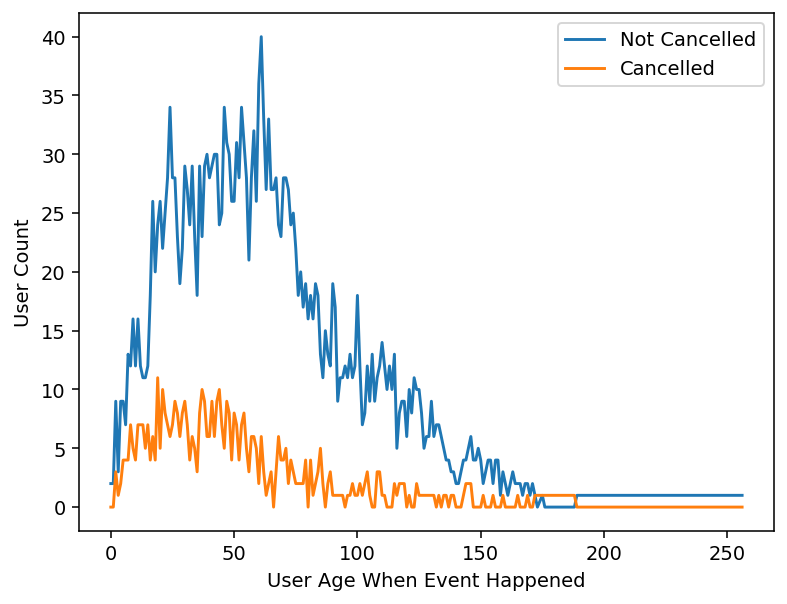

In [ ]:
uc = sppupd_df["users_count"].fillna(0)
uc.columns = ["Not Cancelled", "Cancelled"]

plt.figure(figsize=(8, 6))
uc.plot(xlabel="User Age When Event Happened", ylabel="User Count")

This shows the number of users when it had a certain age. We see that most ages are less than 90. Which is kind of expected, because our window have a 90 days size, meaning that most users would probably have recorded events within this time period. For for than 90 days, we should have more old users, and the first graph of registration date, we see that user registration start slow and increases till we reach the window time begin.

<Axes: title={'center': 'Std Page Interactions'}, xlabel='Activity Date', ylabel='Page Interactions'>

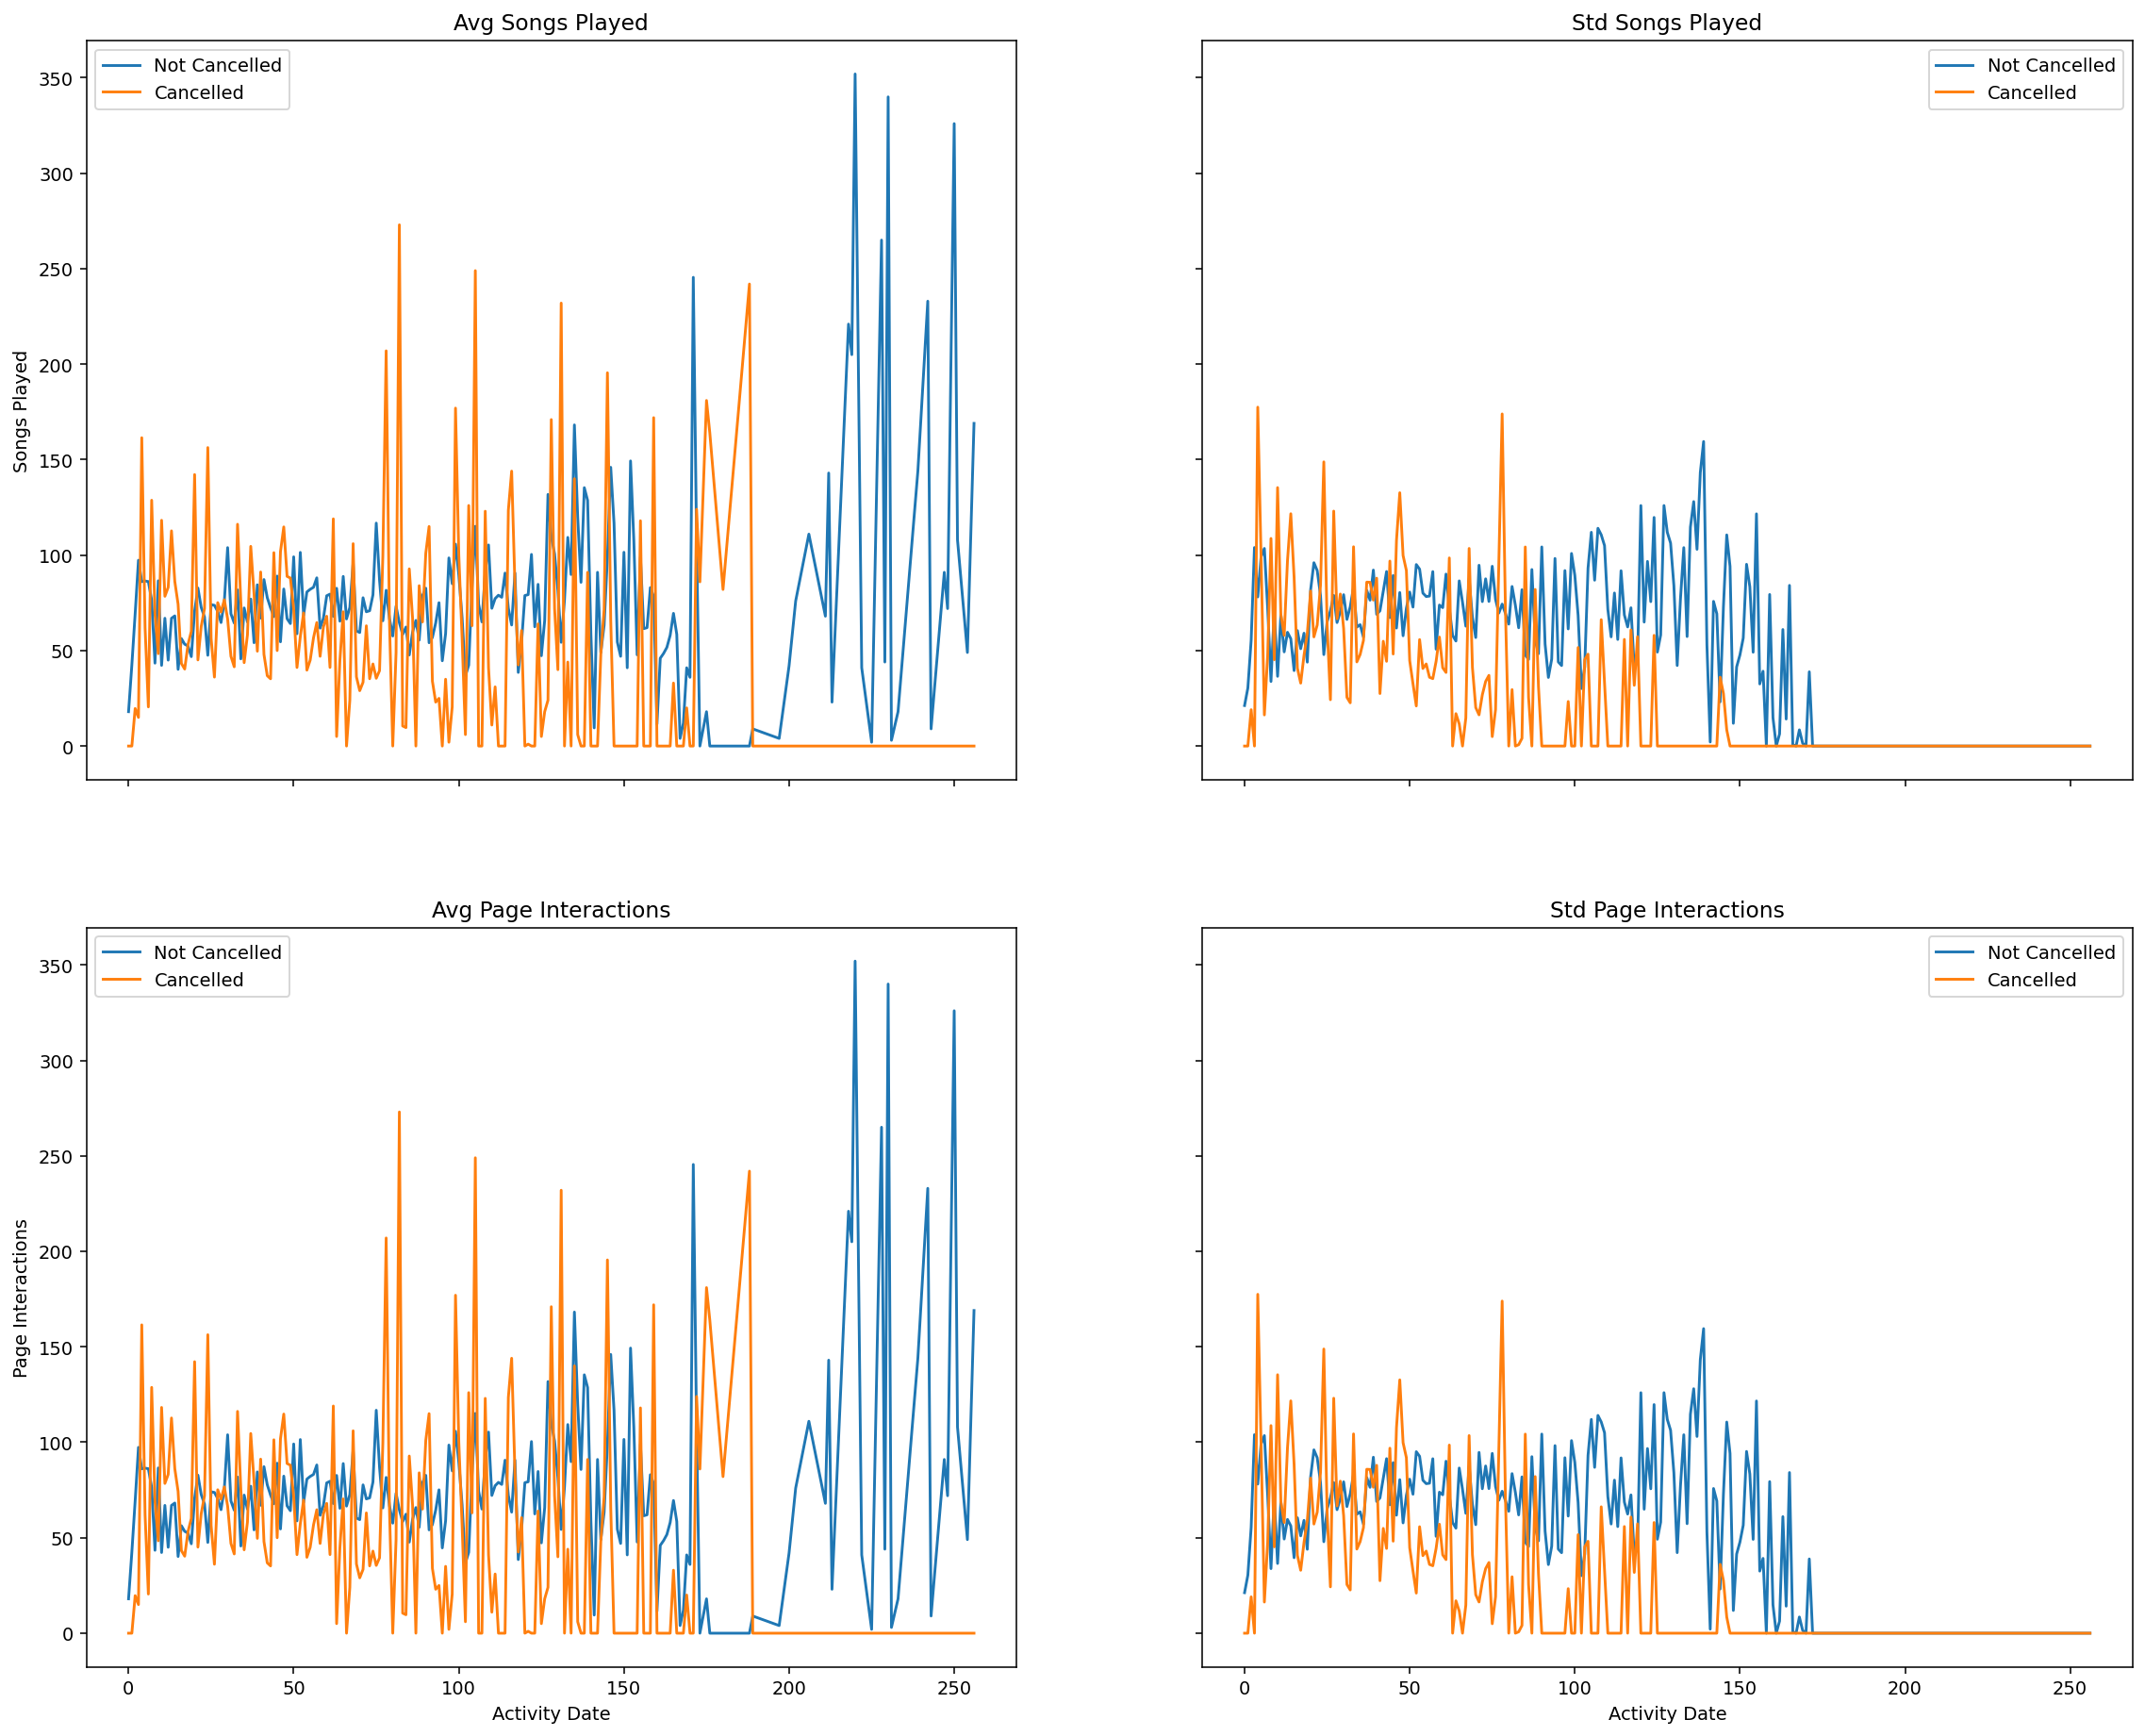

In [ ]:
asp_df = sppupd_df["avg_songs_played"].fillna(0)
asp_df.columns = ["Not Cancelled", "Cancelled"]

api_df = sppupd_df["avg_page_interactions"].fillna(0)
api_df.columns = ["Not Cancelled", "Cancelled"]

ssp_df = sppupd_df["std_songs_played"].fillna(0)
ssp_df.columns = ["Not Cancelled", "Cancelled"]

spi_df = sppupd_df["std_page_interactions"].fillna(0)
spi_df.columns = ["Not Cancelled", "Cancelled"]

fig, axes = plt.subplots(figsize=(20, 16), nrows=2, ncols=2, sharex=True, sharey=True)

asp_df.plot(ax=axes[0, 0], xlabel="Activity Date", ylabel="Songs Played", title="Avg Songs Played")
ssp_df.plot(ax=axes[0, 1], xlabel="Activity Date", ylabel="Songs Played", title="Std Songs Played")

asp_df.plot(ax=axes[1, 0], xlabel="Activity Date", ylabel="Page Interactions", title="Avg Page Interactions")
ssp_df.plot(ax=axes[1, 1], xlabel="Activity Date", ylabel="Page Interactions", title="Std Page Interactions")

For the small dataset the image is noisy. But with full dataset we notice that on average users that cancelled the service tends to listen to more songs and have a higher page interaction than active users. At least up to 150 days of age, then the data is more noisy.

In [ ]:
# Sessions behavior
sessions = spark.sql("""
SELECT activity_time, label,
       COUNT(sessionId) AS sessions,
       AVG(interactions) AS interactions,
       AVG(session_time) AS session_time
FROM
(
    SELECT events.userIdIndex, events.interactions, events.sessionId, events.session_time, events.activity_time, churn.label FROM
    (
        SELECT userIdIndex, sessionId, COUNT(sessionId) AS interactions, MIN(elapsed_days) AS activity_time, (MAX(ts) - MIN(ts))/1000 AS session_time
        FROM sparkify_events
        GROUP BY userIdIndex, sessionId
    ) AS events
    INNER JOIN churn
    ON events.userIdIndex = churn.userIdIndex
)
GROUP BY activity_time, label
ORDER BY activity_time, label
""")

In [ ]:
sessions_df = sessions.toPandas()
sessions_df = sessions_df.pivot(index="activity_time", columns="label").fillna(0)

<Axes: title={'center': 'Mean Session Time per Activity Day'}, xlabel='Activity Day', ylabel='Mean Session Time (s)'>

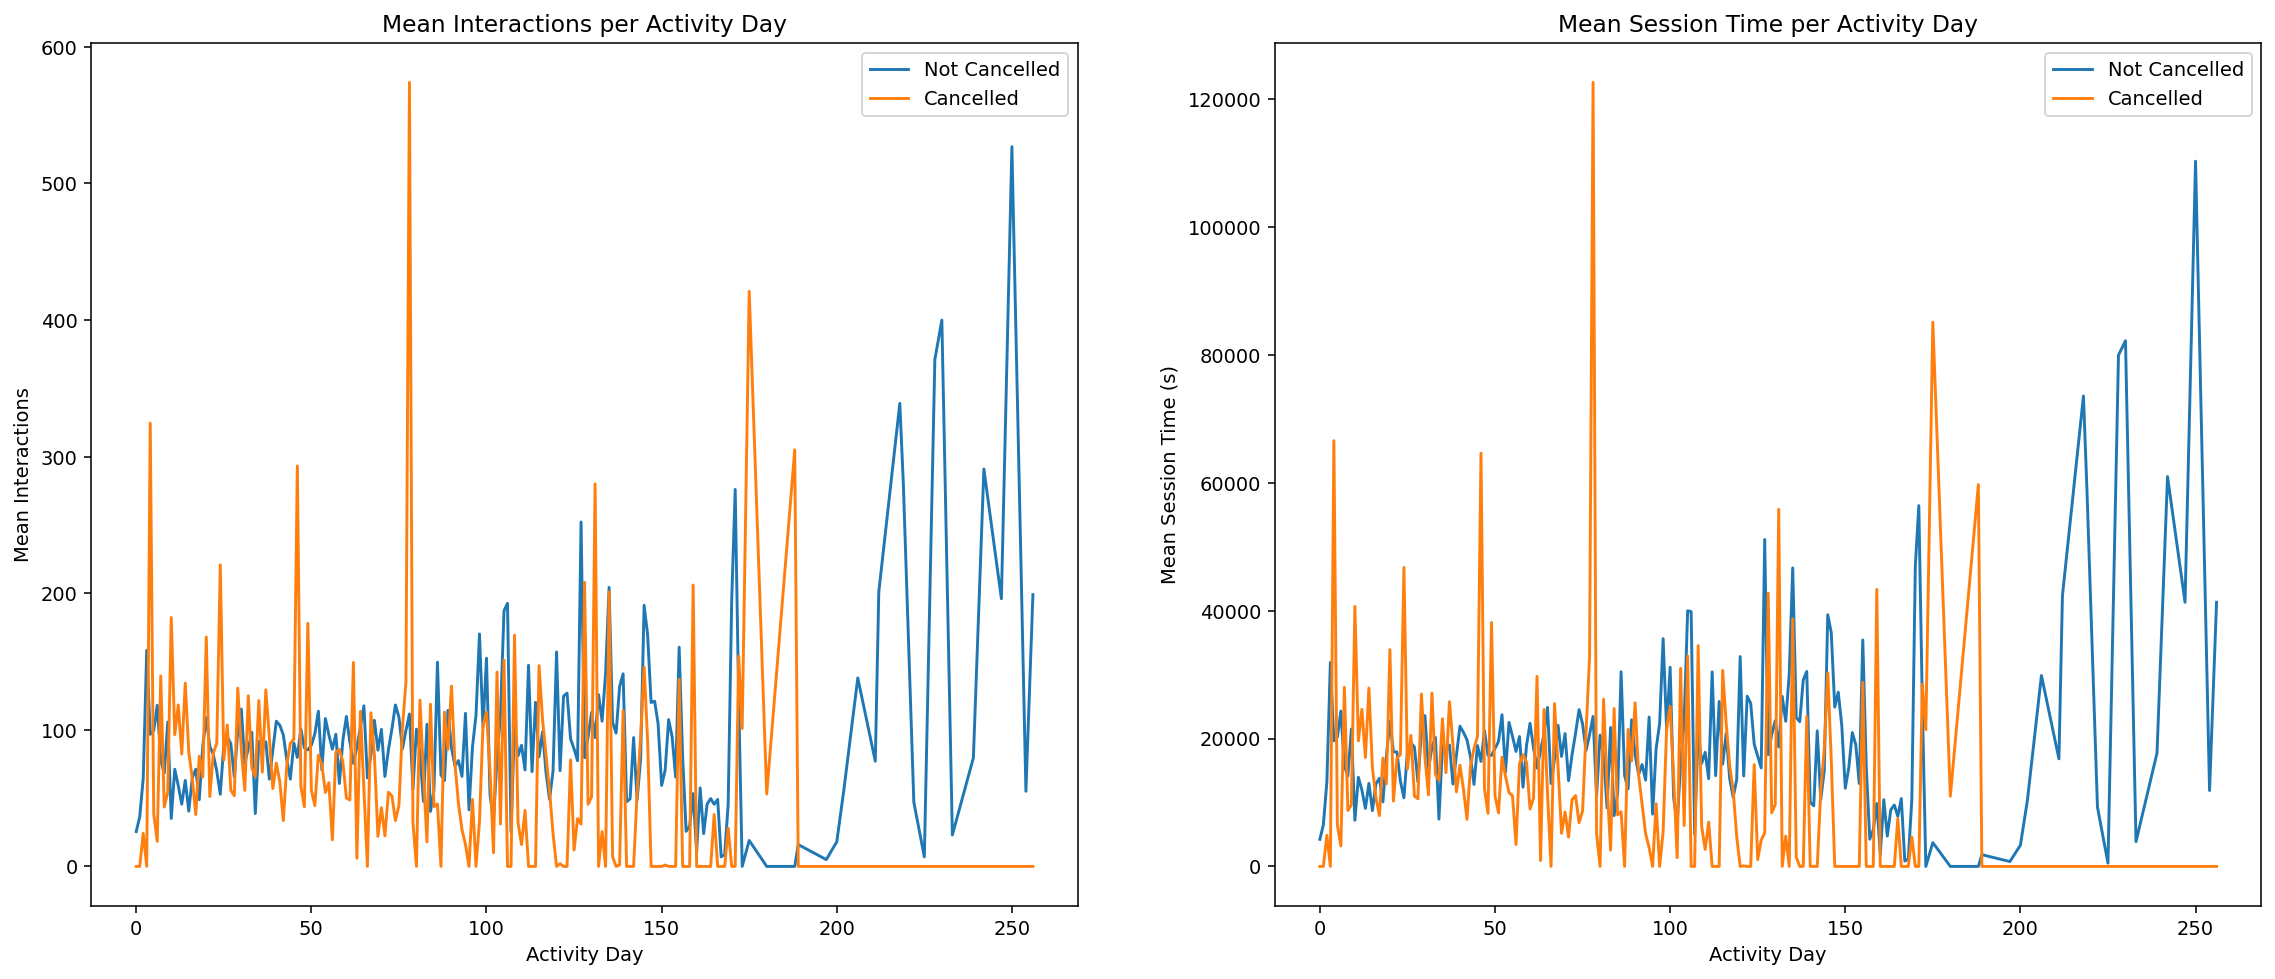

In [ ]:
si_df = sessions_df["interactions"].fillna(0)
si_df.columns = ["Not Cancelled", "Cancelled"]

sst_df = sessions_df["session_time"].fillna(0)
sst_df.columns = ["Not Cancelled", "Cancelled"]

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)

si_df.plot(ax=axes[0], xlabel="Activity Day", ylabel="Mean Interactions", title="Mean Interactions per Activity Day")
sst_df.plot(ax=axes[1], xlabel="Activity Day", ylabel="Mean Session Time (s)", title="Mean Session Time per Activity Day")

Here we cannot see, but in the images of the full dataset we observe that the sessions of active and cancelled users are not very different.

In [ ]:
# Number of distinct artists and songs
spark.sql("""
SELECT COUNT(DISTINCT artist), COUNT(DISTINCT song) FROM sparkify_events
""").toPandas()

,count(DISTINCT artist),count(DISTINCT song)
0,17655,58467


# Feature Engineering

For building the data to be used in a model, we need to aggregate each user data.
Thus we need a dataframe, which each row is a user and each column a feature.

We have pre-processed and collected the following features:
- Latent variables from an ALS (Alternating Least Squares) taken from artists (20 features)
- Percent of a user interaction with a page over all user page interaction (17 features)
- Count of page interaction for each page (17 features)
- Level of a user (`free` or `paid`) (1 feature)
- Percent of events with a level `paid` for each user (1 feature)
- Gender (1 feature)
- Song length mean and stdev (2 features)
- Hourly song count (24 features)
- Hourly song mean length (24 features)
- Age, and average age of a user (2 features)
- Aggregation of user sessions such as sessions count, average and stdev of pages interactions, artist unique count, mean song length and session time (9 features)

For a total of 116 features.

When we take the last week of each user events, we repeat the ALS, page percentage, page count, song length, hourly song count and hourly song mean length for the events of each user last week events. For a total of 221 features.

In [ ]:
# Helper function to prefix columns
# Must have userIdIndex
def prefix_column(dataframe, prefix):
    """Prefix the columns of a dataframe

    Args:
        dataframe (object): A Spark Dataframe with a userIdIndex column, and several other columns
        prefix (str): The string to prefix the other columns

    Returns:
        object: A Spark Dataframe with renamed columns

    """
    cols = dataframe.columns.copy()
    cols.remove("userIdIndex")

    for col in cols:
        dataframe = dataframe.withColumnRenamed(col, f"{prefix}_{col}")

    return dataframe

In [ ]:
# Create features for Artists
# Because of the large number of artists, do a dimensionality reduction with ALS

In [ ]:
# Create an artist rating View for each user
# For each user the rating is the number of songs played for that artist divided by the most song counts of an artist
# Range between 0-1
def create_ratings(table_name):
    """Create a ratings dataframe for a given table with events

    Args:
        table_name (str): The name of SQL table
    """
    rating_df = spark.sql(f"""
    SELECT userIdIndex, artistIndex, COUNT(song) / MAX(COUNT(song)) OVER(PARTITION BY userIdIndex) AS rating
    FROM {table_name}
    WHERE artist IS NOT NULL
    GROUP BY userIdIndex, artistIndex
    """)

    rating_df.createOrReplaceTempView(f"{table_name}_rating")

# Create ratings for both total and last week events
create_ratings("sparkify_events")
create_ratings("last_week_events")

In [ ]:
# Get rating dataframe for whole dataset
rating_df = spark.sql("SELECT * FROM sparkify_events_rating")

In [ ]:
# Create ALS model and train (Reduce to 20 features)
als = ALS(rank=20,
          regParam=0.01,
          userCol="userIdIndex",
          itemCol="artistIndex",
          ratingCol="rating",
          coldStartStrategy="drop")

model = als.fit(rating_df)

In [ ]:
# Get item factors matrix from ALS model
factors = IndexedRowMatrix(model.itemFactors.rdd.map(tuple)).toBlockMatrix().toLocalMatrix()

def get_als_features(ratings, factors, num_factors=20, output_col="vector"):
    """Get features for each user given the ratings dataframe and the item factor matrix.

    Args:
        ratings (object): A Spark Dataframe with the columns userIdIndex, artistIndex and rating
        factors (IndexedRowMatrix): A Matrix with Item Factors from a trained ALS model
        output_col (str): The name of the output column features

    Returns:
        object: A Spark Dataframe with columns userIdIndex and several output_col in the number of number
        of factors

    """
    mat = CoordinateMatrix(ratings.select("userIdIndex", "artistIndex", "rating").rdd.map(tuple))
    mat = mat.toIndexedRowMatrix()

    # Dot multiplication between user-artist ratings matrix and artist factors
    dataframe = mat.multiply(factors).rows.toDF()

    # Transform array to columns
    dataframe = dataframe.withColumn("userIdIndex", dataframe["index"].cast(DoubleType()))
    dataframe = dataframe.withColumn(output_col, vector_to_array("vector"))
    dataframe = dataframe.select(["userIdIndex"] + [dataframe[output_col][i] for i in range(num_factors)])

    return dataframe


# All events
als_features_all = get_als_features(rating_df, factors, output_col="als_features_all")

# Last week events
rating_last_week_df = spark.sql("""
SELECT t.userIdIndex, t.artistIndex, IFNULL(lw.rating, 0) AS rating FROM sparkify_events_rating AS t
LEFT JOIN last_week_events_rating AS lw
ON t.userIdIndex = lw.userIdIndex AND t.artistIndex = lw.artistIndex
""")
als_features_lw = get_als_features(rating_last_week_df, factors, output_col="als_features_lw")

In [ ]:
## Percentage of access for each page for each user
# Remove Cancel and Cancellation Confirmation
def create_page_percentage(table_name):
    """For each user calculate the percentage of a
    specific page interaction over all pages interactions.

    Remove page `Cancel` and `Cancellation Confirmation`
    because they are used to predict churn, not to serve as features.

    Args:
        table_name (str): A Spark SQL table name

    Returns:
        object: A Spark Dataframe

    """

    page_df = spark.sql(f"""
    SELECT userIdIndex, page, COUNT(page) / SUM(COUNT(page)) OVER(PARTITION BY userIdIndex) AS page_perct
    FROM {table_name}
    WHERE page IS NOT NULL AND page != 'Cancel' AND page != 'Cancellation Confirmation'
    GROUP BY userIdIndex, page
    """)

    return page_df

# All events
page_pct_all = create_page_percentage("sparkify_events").groupBy("userIdIndex").pivot("page").sum("page_perct").na.fill(0.)
page_pct_all = prefix_column(page_pct_all, prefix="page_pct_all")

# Last week events
page_pct_lw = create_page_percentage("last_week_events").groupBy("userIdIndex").pivot("page").sum("page_perct").na.fill(0.)
page_pct_lw = prefix_column(page_pct_lw, prefix="page_pct_lw")

In [ ]:
# Total page access
def create_page_counts(table_name):
    """Calculate the number of pages access for each user

    Remove page `Cancel` and `Cancellation Confirmation`
    because they are used to predict churn, not to serve as features.

    Args:
        table_name (str): A Spark SQL table name

    Returns:
        object: A Spark Dataframe
    """

    page_df = spark.sql(f"""
    SELECT userIdIndex, page, COUNT(page) AS page_count
    FROM {table_name}
    WHERE page IS NOT NULL AND page != 'Cancel' AND page != 'Cancellation Confirmation'
    GROUP BY userIdIndex, page
    """)

    return page_df

# All events
page_count_all = create_page_counts("sparkify_events").groupby("userIdIndex").pivot("page").sum("page_count").na.fill(0)
page_count_all = prefix_column(page_count_all, prefix="page_count_all")

# Last week events
page_count_lw = create_page_counts("last_week_events").groupby("userIdIndex").pivot("page").sum("page_count").na.fill(0)
page_count_lw = prefix_column(page_count_lw, prefix="page_count_lw")

In [ ]:
# Level of each user by getting its last reported level
level_indexer = StringIndexer(inputCol="level", outputCol="levelIndex")
level_encoder = OneHotEncoder(inputCols=["levelIndex"], outputCols=["l"])

level = spark.sql(
"""
WITH last_level AS
(
    SELECT userIdIndex, level, ROW_NUMBER() OVER (PARTITION BY userIdIndex ORDER BY ts DESC) AS number
    FROM sparkify_events
)
SELECT userIdIndex, level FROM last_level WHERE number = 1
""")

level = level_indexer.fit(level).transform(level)
level = level_encoder.fit(level).transform(level).select("userIdIndex", "l")
level = level.withColumnRenamed("l", "level")

In [ ]:
# Level percentage
# Drop free (because paid = 1 - free, no necessity to have both as they are linearly dependent, thus highly correlated)
def create_level_percentage(table_name):
    """Calculate the level percentage for each user by using the number of events
    that happened in each level

    Args:
        table_name (str): A Spark SQL table name

    Returns:
        object: A Spark Dataframe
    """

    level_df = spark.sql(f"""
    SELECT userIdIndex, level, COUNT(level) / SUM(COUNT(level)) OVER(PARTITION BY userIdIndex) AS level_perct
    FROM {table_name}
    WHERE level IS NOT NULL
    GROUP BY userIdIndex, level
    """)

    return level_df

# All events
level_pct_all = create_level_percentage("sparkify_events").groupBy("userIdIndex").pivot("level").sum("level_perct").na.fill(0.).drop("free")
level_pct_all = prefix_column(level_pct_all, prefix="level_pct_all")

# Last week events
level_pct_lw = create_level_percentage("last_week_events").groupBy("userIdIndex").pivot("level").sum("level_perct").na.fill(0.).drop("free")
level_pct_lw = prefix_column(level_pct_lw, prefix="level_pct_lw")

In [ ]:
# Gender
gender_encoder = OneHotEncoder(inputCols=["genderIndex"], outputCols=["g"])
gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")

gender = df.groupBy("userIdIndex").agg(F.first("gender").alias("gender"))
gender = gender_indexer.fit(gender).transform(gender)
gender = gender_encoder.fit(gender).transform(gender).select("userIdIndex", "g")
gender = gender.withColumnRenamed("g", "gender")

In [ ]:
# Song length
song_length_all = df.groupBy("userIdIndex").agg(F.mean("length").alias("mean"), F.stddev("length").alias("std")).na.fill(0.)
song_length_all = prefix_column(song_length_all, prefix="song_length_all")

song_length_lw = last_week_df.groupBy("userIdIndex").agg(F.mean("length").alias("mean"), F.stddev("length").alias("std")).na.fill(0.)
song_length_lw = prefix_column(song_length_lw, prefix="song_length_lw")

In [ ]:
# Hourly Song Counts
hourly_song_counts_all = df.select("userIdIndex", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").count().groupBy("userIdIndex").pivot("hour").sum("count").na.fill(0)
hourly_song_counts_all = prefix_column(hourly_song_counts_all, prefix="hourly_song_counts_all")

hourly_song_counts_lw = last_week_df.select("userIdIndex", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").count().groupBy("userIdIndex").pivot("hour").sum("count").na.fill(0)
hourly_song_counts_lw = prefix_column(hourly_song_counts_lw, prefix="hourly_song_counts_lw")

In [ ]:
# Hourly Mean Song Length
hourly_mean_song_length_all = df.select("userIdIndex", "length", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").mean("length").groupBy("userIdIndex").pivot("hour").mean("avg(length)").na.fill(0)
hourly_mean_song_length_all = prefix_column(hourly_mean_song_length_all, prefix="hourly_mean_song_length_all")

hourly_mean_song_length_lw = last_week_df.select("userIdIndex", "length", F.hour(F.from_unixtime(df.ts/1000)).alias("hour")).groupBy("userIdIndex", "hour").mean("length").groupBy("userIdIndex").pivot("hour").mean("avg(length)").na.fill(0)
hourly_mean_song_length_lw = prefix_column(hourly_mean_song_length_lw, prefix="hourly_mean_song_length_lw")

In [ ]:
elapsed_days = spark.sql("""
SELECT userIdIndex, MAX(elapsed_days) AS age, AVG(elapsed_days) AS avg_age
FROM sparkify_events
GROUP BY userIdIndex
""")

In [ ]:
sessions = spark.sql("""
SELECT userIdIndex,
       COUNT(sessionId) AS sessions_count,
       AVG(pages_accessed) AS sessions_avg_pages_accessed,
       AVG(count_artists) AS sessions_avg_count_artists,
       AVG(avg_song_length) AS sessions_avg_song_length,
       AVG(session_time) AS sessions_avg_session_time,
       STD(pages_accessed) AS sessions_std_pages_accessed,
       STD(count_artists) AS sessions_std_count_artists,
       STD(avg_song_length) AS sessions_std_song_length,
       STD(session_time) AS sessions_std_session_time
FROM
(
    SELECT userIdIndex, sessionId, COUNT(song) AS songs_played, COUNT(page) AS pages_accessed,
           COUNT(DISTINCT artist) AS count_artists, AVG(length) AS avg_song_length,
           (MAX(ts) - MIN(ts)) / 1000 AS session_time
    FROM sparkify_events
    GROUP BY userIdIndex, sessionId
)
GROUP BY userIdIndex
""")
# Fill std NAs with 0
sessions = sessions.fillna(0.)

In [ ]:
# Features Dataframe with no last week

In [ ]:
no_lw_features = als_features_all.join(page_pct_all, on=["userIdIndex"])\
                   .join(page_count_all, on=["userIdIndex"])\
                   .join(level_pct_all, on=["userIdIndex"])\
                   .join(song_length_all, on=["userIdIndex"])\
                   .join(hourly_song_counts_all, on=["userIdIndex"])\
                   .join(hourly_mean_song_length_all, on=["userIdIndex"])\
                   .join(elapsed_days, on=["userIdIndex"])\
                   .join(sessions, on=["userIdIndex"])\
                   .join(churn, on=["userIdIndex"])

In [ ]:
no_lw_features.printSchema()

root
 |-- userIdIndex: double (nullable = true)
 |-- als_features_all[0]: double (nullable = true)
 |-- als_features_all[1]: double (nullable = true)
 |-- als_features_all[2]: double (nullable = true)
 |-- als_features_all[3]: double (nullable = true)
 |-- als_features_all[4]: double (nullable = true)
 |-- als_features_all[5]: double (nullable = true)
 |-- als_features_all[6]: double (nullable = true)
 |-- als_features_all[7]: double (nullable = true)
 |-- als_features_all[8]: double (nullable = true)
 |-- als_features_all[9]: double (nullable = true)
 |-- als_features_all[10]: double (nullable = true)
 |-- als_features_all[11]: double (nullable = true)
 |-- als_features_all[12]: double (nullable = true)
 |-- als_features_all[13]: double (nullable = true)
 |-- als_features_all[14]: double (nullable = true)
 |-- als_features_all[15]: double (nullable = true)
 |-- als_features_all[16]: double (nullable = true)
 |-- als_features_all[17]: double (nullable = true)
 |-- als_features_all[18]:

In [ ]:
# Features Dataframe with last week
a1 = als_features_all.join(als_features_lw, on=["userIdIndex"])
p1 = page_pct_all.join(page_pct_lw, on=["userIdIndex"])
p2 = page_count_all.join(page_count_lw, on=["userIdIndex"])
l1 = level_pct_all.join(level_pct_lw, on=["userIdIndex"])
s1 = song_length_all.join(song_length_lw, on=["userIdIndex"])
h1 = hourly_song_counts_all.join(hourly_song_counts_lw, on=["userIdIndex"])
h2 = hourly_mean_song_length_all.join(hourly_mean_song_length_lw, on=["userIdIndex"])

In [ ]:
features = a1.join(p1, on=["userIdIndex"])\
             .join(p2, on=["userIdIndex"])\
             .join(l1, on=["userIdIndex"])\
             .join(s1, on=["userIdIndex"])\
             .join(h1, on=["userIdIndex"])\
             .join(h2, on=["userIdIndex"])\
             .join(elapsed_days, on=["userIdIndex"])\
             .join(sessions, on=["userIdIndex"])\
             .join(churn, on=["userIdIndex"])

In [ ]:
features.printSchema()

root
 |-- userIdIndex: double (nullable = true)
 |-- als_features_all[0]: double (nullable = true)
 |-- als_features_all[1]: double (nullable = true)
 |-- als_features_all[2]: double (nullable = true)
 |-- als_features_all[3]: double (nullable = true)
 |-- als_features_all[4]: double (nullable = true)
 |-- als_features_all[5]: double (nullable = true)
 |-- als_features_all[6]: double (nullable = true)
 |-- als_features_all[7]: double (nullable = true)
 |-- als_features_all[8]: double (nullable = true)
 |-- als_features_all[9]: double (nullable = true)
 |-- als_features_all[10]: double (nullable = true)
 |-- als_features_all[11]: double (nullable = true)
 |-- als_features_all[12]: double (nullable = true)
 |-- als_features_all[13]: double (nullable = true)
 |-- als_features_all[14]: double (nullable = true)
 |-- als_features_all[15]: double (nullable = true)
 |-- als_features_all[16]: double (nullable = true)
 |-- als_features_all[17]: double (nullable = true)
 |-- als_features_all[18]:

In [ ]:
def assembler(features_df):
    """Transform the features columns into a single feature column as a vector

    Args:
        features_df (object): A Spark Dataframe with columns: userIdIndex, several features, label

    """
    cols = features_df.columns.copy()
    cols.remove("userIdIndex")
    cols.remove("label")

    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    features_df = assembler.transform(features_df).select("userIdIndex", "features", "label")

    return features_df

In [ ]:
# Assemble features dataframes
no_lw_features = assembler(no_lw_features)
features = assembler(features)

# Modeling

We tested four models for our dataset.
- Random Forest
- Logistic Regression
- GBT Classifier
- Linear SVM

We first test them with our dataset without last week features.

Then, we try to improve our methods with:
- Add the last week features
- Add weights to our users (since churned users are less than our active users)

We select our best two methods, and train the whole dataset in it, on the other notebook, which is exactly like this, but with only two models.

We select `F1 score` as our main metric, because we have fewer churned users than active and a high accuracy model will not imply in a good classifer of churned users.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# We will use F1 score as the main metric
# We have few examples of churned users, and accuracy would be high if we predict everyone will not cancel
# This is also a binary classification
# Thus using F1 is a compromise between precision and recall

In [ ]:
def train_test_several_models(training_set, test_set, classifiers=["Random Forest", "Logistic Regression", "GBT Classifier", "Linear SVM", "Decision Tree"], weights=False):
    """Train several models, predict, and show fscore for each

    Args:
        training_set (object): A Spark Dataframe with columns userIdIndex, features, label
        test_set (object): A Spark Dataframe with columns userIdIndex, features, label
        classifiers (list): A list with classifier names to train

    """
    # Scale features
    print("Scaling features...")
    scaler_model = MaxAbsScaler(inputCol="features", outputCol="scaled_features").fit(training_set)
    training_set = scaler_model.transform(training_set)
    test_set = scaler_model.transform(test_set)

    # Classifiers
    classifiers_dict = {
        "Random Forest": RandomForestClassifier(featuresCol="scaled_features", numTrees=100),
        "Logistic Regression": LogisticRegression(featuresCol="scaled_features"),
        "GBT Classifier": GBTClassifier(featuresCol="scaled_features", maxIter=100),
        "Linear SVM": LinearSVC(featuresCol="scaled_features"),
        "Decision Tree": DecisionTreeClassifier(featuresCol="scaled_features"),
    }
    if weights:
        classifiers_dict = {
            "Random Forest": RandomForestClassifier(featuresCol="scaled_features", weightCol="weights", numTrees=100),
            "Logistic Regression": LogisticRegression(featuresCol="scaled_features", weightCol="weights"),
            "GBT Classifier": GBTClassifier(featuresCol="scaled_features", weightCol="weights", maxIter=100),
            "Linear SVM": LinearSVC(featuresCol="scaled_features", weightCol="weights"),
            "Decision Tree": DecisionTreeClassifier(featuresCol="scaled_features", weightCol="weights")

        }

    models = {}
    predictions = {}
    fscores = {}

    for clf_name in classifiers:
        print(f"Training {clf_name}")
        # Train Model
        models[clf_name] = classifiers_dict[clf_name].fit(training_set)

        # Predict
        predictions[clf_name] = models[clf_name].transform(test_set)

        # Calculate fscores
        fscores[clf_name] = MulticlassClassificationEvaluator().evaluate(predictions[clf_name])
        print(f"{clf_name}: {fscores[clf_name]}")

    return models, predictions, fscores

In [ ]:
# Train with no last week features
# Split the data into training and test sets 75/25
(training, test) = no_lw_features.randomSplit([0.75, 0.25], seed=42)
train_test_several_models(training, test)

Scaling features...
Training Random Forest
Random Forest: 0.7419274092615769
Training Logistic Regression
Logistic Regression: 0.7797536394176932
Training GBT Classifier
GBT Classifier: 0.7633122484186314
Training Linear SVM
Linear SVM: 0.7872340425531915
Training Decision Tree
Decision Tree: 0.8128992409342848


({'Random Forest': RandomForestClassificationModel: uid=RandomForestClassifier_1851ba521e4b, numTrees=100, numClasses=2, numFeatures=116,
  'Logistic Regression': LogisticRegressionModel: uid=LogisticRegression_902118ca51ac, numClasses=2, numFeatures=116,
  'GBT Classifier': GBTClassificationModel: uid = GBTClassifier_0eeeb0063edc, numTrees=100, numClasses=2, numFeatures=116,
  'Linear SVM': LinearSVCModel: uid=LinearSVC_1dd381d7d986, numClasses=2, numFeatures=116,
  'Decision Tree': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cf56aee437d4, depth=5, numNodes=35, numClasses=2, numFeatures=116},
 {'Random Forest': DataFrame[userIdIndex: double, features: vector, label: int, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  'Logistic Regression': DataFrame[userIdIndex: double, features: vector, label: int, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  'GBT Classifier': DataFrame[userIdI

The best model was Decision Trees and Linear SVM. Let's add the last week features and see if there are any changes.

In [ ]:
# Train with last week features
(training, test) = features.randomSplit([0.75, 0.25], seed=42)
train_test_several_models(training, test)

Scaling features...
Training Random Forest
Random Forest: 0.7419274092615769
Training Logistic Regression
Logistic Regression: 0.6918117343649258
Training GBT Classifier
GBT Classifier: 0.7872340425531915
Training Linear SVM
Linear SVM: 0.6689705902763321
Training Decision Tree
Decision Tree: 0.7397088465845465


({'Random Forest': RandomForestClassificationModel: uid=RandomForestClassifier_c34b1a2373b1, numTrees=100, numClasses=2, numFeatures=221,
  'Logistic Regression': LogisticRegressionModel: uid=LogisticRegression_ad57f2a73b94, numClasses=2, numFeatures=221,
  'GBT Classifier': GBTClassificationModel: uid = GBTClassifier_c28aa67caf8d, numTrees=100, numClasses=2, numFeatures=221,
  'Linear SVM': LinearSVCModel: uid=LinearSVC_ceb815e23732, numClasses=2, numFeatures=221,
  'Decision Tree': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5347f89975e8, depth=5, numNodes=31, numClasses=2, numFeatures=221},
 {'Random Forest': DataFrame[userIdIndex: double, features: vector, label: int, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  'Logistic Regression': DataFrame[userIdIndex: double, features: vector, label: int, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  'GBT Classifier': DataFrame[userIdI

Adding the last week seemed not to improve models

We will keep it because of this 1% increase in F1 score.

And let's add weights.

In [ ]:
# Weight by label ratio
calc_weights = F.udf(lambda x: churn_rate if x == 0 else (1. - churn_rate), DoubleType())
features = features.withColumn("weights", calc_weights("label"))

In [ ]:
# Train with weights
(training, test) = features.randomSplit([0.75, 0.25], seed=42)
models, predictions, fscores = train_test_several_models(training, test, weights=True)

Scaling features...
Training Random Forest
Random Forest: 0.8217007294166998
Training Logistic Regression
Logistic Regression: 0.7397088465845465
Training GBT Classifier
GBT Classifier: 0.7858044995905679
Training Linear SVM
Linear SVM: 0.755505785740948
Training Decision Tree
Decision Tree: 0.7688588007736944


This was more substancial. We will check the metrics of the Random Forest.

In [ ]:
# Metrics
pred = predictions["Random Forest"].select("label", "prediction").toPandas()
y_true = pred["label"]
y_pred = pred["prediction"]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92        39
           1       0.67      0.25      0.36         8

    accuracy                           0.85        47
   macro avg       0.77      0.61      0.64        47
weighted avg       0.83      0.85      0.82        47



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print(cm)

[[38  1]
 [ 6  2]]


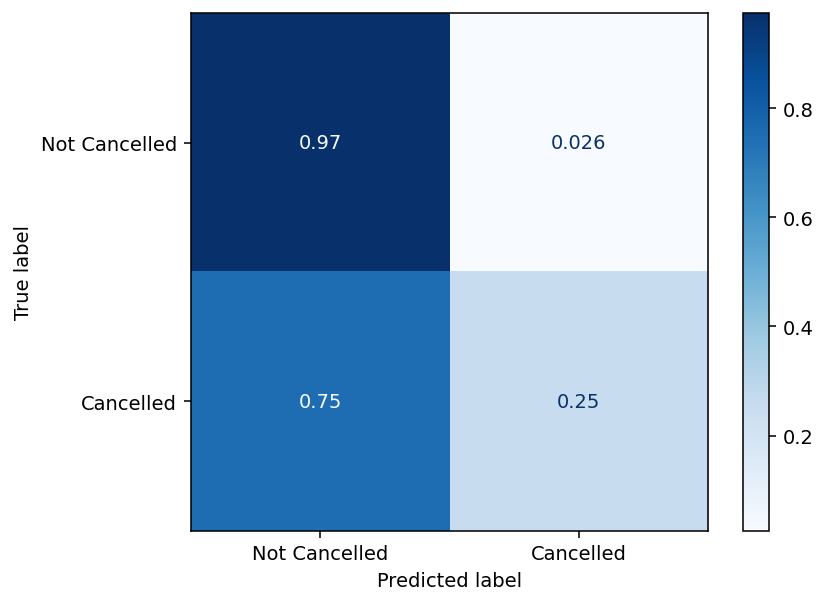

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Cancelled", "Cancelled"])
disp.plot(cmap=plt.cm.Blues)

The model is good for predicting active users but not so much users that cancelled our services, which is more important.
We will see how this model works with more data. And then suggest what should be done.

In [ ]:
# Get feature coefficients for Logistic Regression
f_names = features.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
f_names = [x["name"] for x in f_names]

In [ ]:
f_imp = pd.DataFrame(np.array(models["Logistic Regression"].coefficients), index=f_names).sort_values(by=0, ascending=False)
f_imp

,0
page_pct_lw_Downgrade,52.265282
page_count_lw_Save Settings,47.412098
page_pct_lw_Settings,44.317253
page_pct_all_Home,39.519958
page_count_lw_Downgrade,31.276241
...,...
page_count_all_About,-75.555163
age,-75.721359
song_length_lw_mean,-76.503258
page_pct_lw_Logout,-88.949691


In [ ]:
f_imp = f_imp.abs().sort_values(by=0, ascending=False)
f_imp

,0
song_length_all_mean,213.195242
page_pct_lw_Logout,88.949691
song_length_lw_mean,76.503258
age,75.721359
page_count_all_About,75.555163
...,...
hourly_mean_song_length_lw_4,1.152499
als_features_lw[12],1.126167
page_pct_lw_NextSong,1.100484
page_count_lw_Settings,0.576841


# **LIME**

In [90]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a066b5094894f125ce3cbe074152aedbd046816075bf8d008d29ca5b142ef227
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [91]:
import lime
import lime.lime_tabular


import lightgbm as lgb

# For converting textual categories to integer labels
from sklearn.preprocessing import LabelEncoder

# for creating train test split
from sklearn.model_selection import train_test_split

# specify your configurations as a dict
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss','objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':100,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}




